### Introduction
We all know that the news of Bitcoin's skyrocketing swept the world in 2017. This news shocked me, because a few people a few years ago because of their interest in investing in a few bitcoins have now increased their value by tens or even hundreds of times, and some people have embarked on the path of being rich.

This bitcoin market that made me jealous made me start to try it, but I did n’t have any experience in cryptocurrency investment, nor did I observe the stock market and market-related minds. So, while I may not have a ticket to the moon, I can at least get on board the hype train by successfully predicting the price of cryptos by harnessing machine learning and deep learning.

### Methodology
We are going to employ a Long Short Term Memory (LSTM) model, which is a particular type of deep learning model that is well suited to time series data, to predict bitcoin's everyday closing price.

### Data
Before we build the model, we need to get some data to let the model learn. So it may be a good idea to extract data from a data source. We will use the website "coinmarketcap.com". It contains the daily price data of most mainstream cryptocurrencies on the market. Currently I only consider Bitcoin data, but it is not too difficult to add other currencies in this way.

First of all, we have to import some python packages

In [1]:
# import basic libraries
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
sns.set()

Second, with the help of pandas, we can pull data directly from this website, and doing data preprocessing.

In [2]:
# get market info for bitcoin from the start of 2013 to the current day
df_bitcoin = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[2]
# convert the date string to the correct date format
df_bitcoin = df_bitcoin.assign(Date=pd.to_datetime(df_bitcoin['Date']))
# rename some of the columns
df_bitcoin.rename(columns={"Open*":"Open","Close**":"Close"}, inplace = True)
# sort by date and thus reset index
df_bitcoin = df_bitcoin.sort_values(by = 'Date')
df_bitcoin.reset_index(inplace=True)
df_bitcoin=df_bitcoin.drop('index',axis=1)
# look at the first few rows
df_bitcoin.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2013-04-28,135.30,135.98,132.10,134.21,0,1488566728
1,2013-04-29,134.44,147.49,134.00,144.54,0,1603768865
2,2013-04-30,144.00,146.93,134.05,139.00,0,1542813125
3,2013-05-01,139.00,139.89,107.72,116.99,0,1298954594
4,2013-05-02,116.38,125.60,92.28,105.21,0,1168517495


In [3]:
# look at the last few rows
df_bitcoin.tail()

,Date,Open,High,Low,Close,Volume,Market Cap
2569,2020-05-10,9591.17,9595.58,8395.11,8756.43,63325279337,160884755211
2570,2020-05-11,8755.54,9033.47,8374.32,8601.80,57119858802,158059235276
2571,2020-05-12,8610.39,8949.90,8569.64,8804.48,42142717533,161791577301
2572,2020-05-13,8805.39,9317.88,8805.39,9269.99,45558144023,170352710071
2573,2020-05-14,9271.33,9793.27,9255.03,9733.72,56426907637,178881641547


Take a look at the shape of all these data, and make a confirmation that all the values is not null.

In [4]:
# check data shape
df_bitcoin.shape

(2574, 7)

In [5]:
# check null values
df_bitcoin.isnull().values.any()

False

The obtained data has no null values, which is great because we donot have to do more preprocessing about null values at all.
To have a more general look into the values, we can plot the closing price over time.

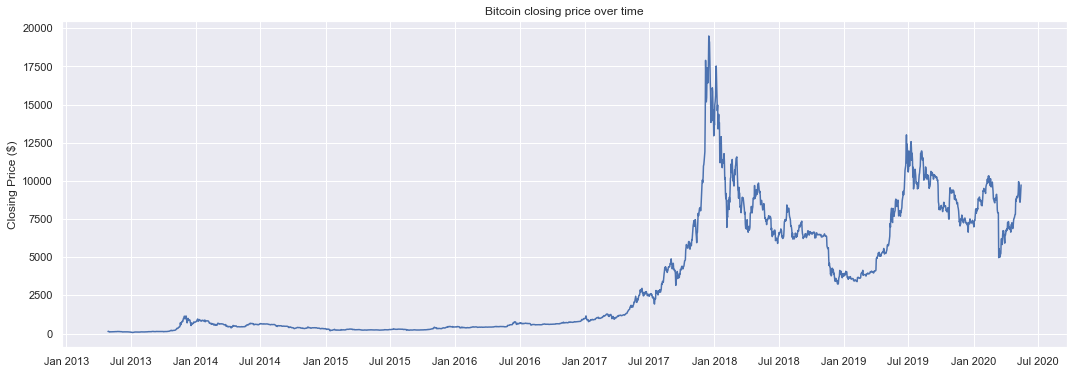

In [6]:
# Create a new figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title('Bitcoin closing price over time')
ax.set_ylabel('Closing Price ($)')
ax.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,7]])
ax.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,7]])
ax.plot(df_bitcoin['Date'],df_bitcoin['Close'])
plt.show()

We must process the data before feeding it to the model, because most machine learning models do not like the input data to change greatly. So here is the normalization with the help of sklearn package, so that all closing prices are distributed between 0 and 1.

In [7]:
from sklearn.preprocessing import MinMaxScaler
#extract closing price data from dataframe
df_bitcoin_closing=df_bitcoin[['Date','Close']]
# drop data when scaling
df_bitcoin_closing_without_date=df_bitcoin_closing.drop('Date',axis=1)
# Let the data be distributed between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_bitcoin_closing_without_date.values)
# add index to the transformed data
df_bitcoin_closing_without_date_scaled=df_bitcoin_closing_without_date
#print(bitcoin_market_info.values)
df_bitcoin_closing_without_date_scaled.loc[:,:] = scaled_data

In [8]:
# have a look at the scaled closing price
df_bitcoin_closing_without_date_scaled

,Close
0,0.003386
1,0.003917
2,0.003632
3,0.002499
4,0.001893
...,...
2569,0.447167
2570,0.439209
2571,0.449640
2572,0.473600


### Training set and test set
We have some data, so now we need to build a model. In deep learning, the data is typically split into training and test sets. The model is built on the training set and subsequently evaluated on the unseen test set. In time series models, we generally train on one period of time and then test on another separate period. 
Thus, I set the cut-off date to January 1st 2019, which means model will be trained on data before that date and assessed on data after it.

In [9]:
split_date = '2019-01-01'
training_set, test_set = df_bitcoin_closing_without_date_scaled[df_bitcoin_closing['Date']<split_date], df_bitcoin_closing_without_date_scaled[df_bitcoin_closing['Date']>=split_date]
#training_set = training_set.drop('Date', axis=1)
#test_set = test_set.drop('Date', axis=1)
print(training_set, test_set,sep="\n---------------\n")

         Close
0     0.003386
1     0.003917
2     0.003632
3     0.002499
4     0.001893
...        ...
2069  0.184590
2070  0.198440
2071  0.193113
2072  0.195457
2073  0.189113

[2074 rows x 1 columns]
---------------
         Close
2074  0.194302
2075  0.199443
2076  0.193953
2077  0.195033
2078  0.194388
...        ...
2569  0.447167
2570  0.439209
2571  0.449640
2572  0.473600
2573  0.497468

[500 rows x 1 columns]


The LSTM model uses the previous data to predict the closing price of Bitcoin the next day. We must decide how many days before the model needs to obtain the data.
My choice is 7 days, because 7 is my lucky number.
We create a small data frame that contains 7 consecutive days of data called windows, so the first window will contain rows 0-6 of the training set and the second window is rows 1-7, and so on.

In [10]:
window_len = 7
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)

LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set)


The table below represents an example of our LSTM model input. Due to window_len equals to 7, so the first element in LSTM_training_inputs contains 7 values, whose index is 0-6.

In [11]:
# the first element of inputs
LSTM_training_inputs[0]

,Close
0,0.003386
1,0.003917
2,0.003632
3,0.002499
4,0.001893
5,0.001509
6,0.002268


In [12]:
# process data with numpy would be more efficient
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)
LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

LSTM_training_outputs = training_set['Close'][window_len:].values
LSTM_test_outputs = test_set['Close'][window_len:].values

In [13]:
# take a look at the output size
print(LSTM_training_outputs.size,LSTM_test_outputs.size)

2067 493


### Build model and make prediction
Now we have to perform a deep learning to realize LSTM. I'll opt for Keras, as I find it the most intuitive for non-experts (like me :) ).

In [14]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


As a first step, we need to instantiate the Sequential class. This will be our model and we will add LSTM, Dropout and Dense layers to this model.
Dropout layer is added to avoid over-fitting, which is a phenomenon where a machine learning model performs better on the training data compared to the test data.
To make our model more robust, we add a dense layer. The number of neurons in the dense layer will be set to 1 since we want to predict a single value in the output.
Finally, we need to compile our LSTM before we can train it on the training data. We use compile() function to conpile our model.
We call the compile method on the Sequential model object which is "model" in our case. We use the mean absolute error as loss function  to reduce the loss and use the adam optimizer to optimize the algorithm.

In [15]:
def build_LSTM_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    # initialize Sequential class
    model = Sequential()
    # add LSTM layer
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    # add Dropout layer to avoid over fitting
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


Now, we just need to specify the number of neurons to place in the LSTM layer. To make a clear comparasion, we try 2 different neurons and epochs, namely (neurons = 5,epochs=12) and (neurons = 20,epochs=27). (I have opt these values to make runtime and result reasonable).
batch_size is set to 1 and verbose is set to 2 to see the number of every epoch.

In [16]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
LSTM_model = build_LSTM_model(LSTM_training_inputs, output_size=1, neurons = 5)
# model output is next price normalised to 7th previous closing price

# train model
bitcoin_history = LSTM_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=12, batch_size=1, verbose=2, shuffle=True)

Epoch 1/12
 - 12s - loss: 0.0326
Epoch 2/12
 - 12s - loss: 0.0245
Epoch 3/12
 - 12s - loss: 0.0227
Epoch 4/12
 - 11s - loss: 0.0230
Epoch 5/12
 - 12s - loss: 0.0234
Epoch 6/12
 - 11s - loss: 0.0237
Epoch 7/12
 - 11s - loss: 0.0222
Epoch 8/12
 - 11s - loss: 0.0218
Epoch 9/12
 - 11s - loss: 0.0225
Epoch 10/12
 - 11s - loss: 0.0226
Epoch 11/12
 - 11s - loss: 0.0226
Epoch 12/12
 - 11s - loss: 0.0214


If everything went to plan, then we'd expect the training error to have gradually decreased over time.

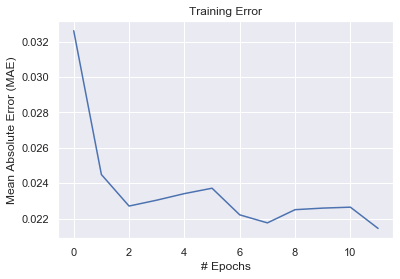

In [17]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(bitcoin_history.epoch, bitcoin_history.history['loss'])
ax1.set_title('Training Error')
ax1.set_xlabel("# Epochs")
ax1.set_ylabel("Mean Absolute Error (MAE)")
plt.show()

Finally, what we need to do is to turn the normalised price back into price in $, and then see if the predicted value matches the actual value.

In [18]:
# using test_inputs to predict closing price
predicted_closing_price = LSTM_model.predict(LSTM_test_inputs)
# now we inverse_transform the normalised data into real price
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)
# put it into panda frame
df_predicted_closing_price=pd.DataFrame(predicted_closing_price,columns=['Close']) 
# generate predicted date set
predicted_date=[(datetime.datetime.strptime(split_date, '%Y-%m-%d') + 
                 datetime.timedelta(days=window_len+i)).strftime('%Y-%m-%d') for i in range(LSTM_test_outputs.size)]
# add predicted date set into panda frame
df_predicted_closing_price['Date'] = predicted_date
df_predicted_closing_price = df_predicted_closing_price[['Date','Close']]
df_predicted_closing_price = df_predicted_closing_price.assign(Date=pd.to_datetime(df_predicted_closing_price['Date']))
df_predicted_closing_price

,Date,Close
0,2019-01-08,3794.478027
1,2019-01-09,3815.546631
2,2019-01-10,3827.392334
3,2019-01-11,3669.507568
4,2019-01-12,3573.678711
...,...,...
488,2020-05-10,9176.514648
489,2020-05-11,8733.892578
490,2020-05-12,8386.252930
491,2020-05-13,8297.516602


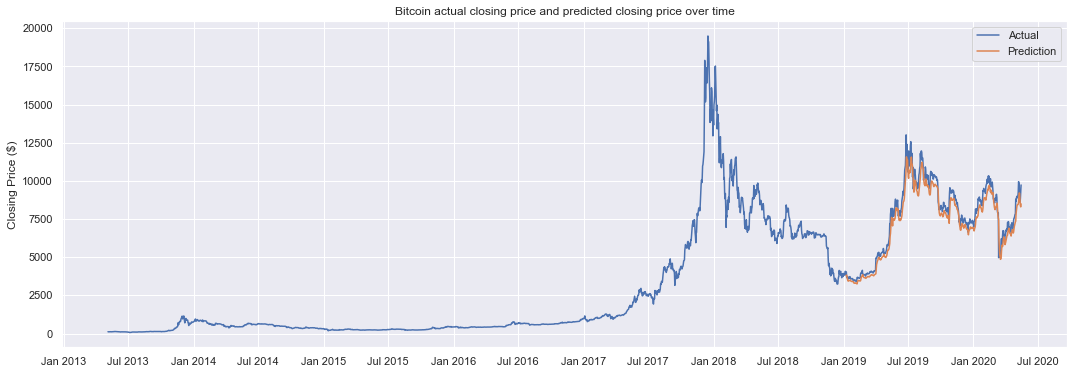

In [19]:
# Create a new figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title('Bitcoin actual closing price and predicted closing price over time')
ax.set_ylabel('Closing Price ($)')
ax.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,7]])
ax.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,7]])
ax.plot(df_bitcoin['Date'][window_len:],df_bitcoin['Close'][window_len:],label='Actual')
ax.plot(df_predicted_closing_price['Date'],df_predicted_closing_price['Close'],label="Prediction")
ax.legend()
plt.show()

Let's zoom up and only focus on the predicted part.

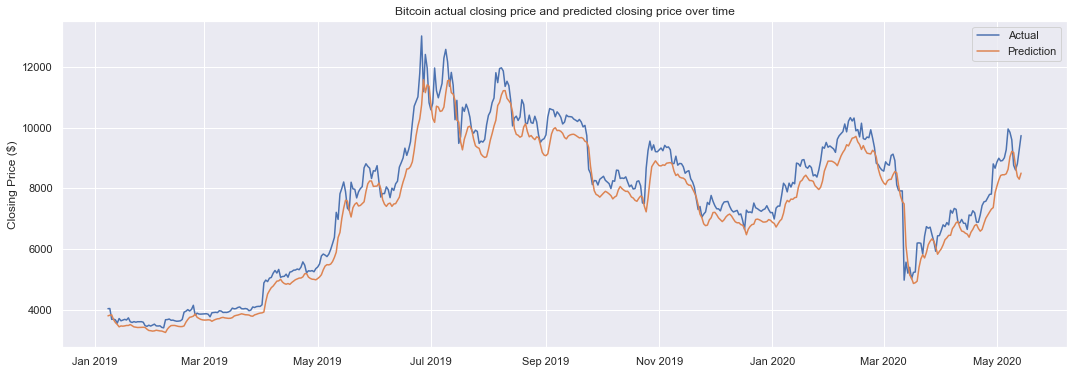

In [20]:
# Create a new figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title('Bitcoin actual closing price and predicted closing price over time')
ax.set_ylabel('Closing Price ($)')
ax.set_xticks([datetime.date(i,j,1) for i in range(2019,2021) for j in [1,3,5,7,9,11]])
ax.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2019,2021) for j in [1,3,5,7,9,11]])
ax.plot(df_bitcoin[df_bitcoin['Date'] >= split_date]['Date'][window_len:],
         df_bitcoin[df_bitcoin['Date'] >= split_date]['Close'][window_len:],label='Actual')
ax.plot(df_predicted_closing_price['Date'],df_predicted_closing_price['Close'],label="Prediction")
ax.legend()
plt.show()

From the figure above, we cannot say our prediction is in a good condition when neuros=5 and epochs=12. Although the overall trend follows very well, but the predicted value is far below the actual value.
Now let's see what will happen if we set neurons=20 and epochs=27.

In [21]:
# initialise model architecture
LSTM_model = build_LSTM_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 7th previous closing price

# train model
bitcoin_history = LSTM_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=27, batch_size=1, verbose=2, shuffle=True)

Epoch 1/27
 - 13s - loss: 0.0215
Epoch 2/27
 - 12s - loss: 0.0163
Epoch 3/27
 - 12s - loss: 0.0159
Epoch 4/27
 - 12s - loss: 0.0163
Epoch 5/27
 - 12s - loss: 0.0161
Epoch 6/27
 - 12s - loss: 0.0149
Epoch 7/27
 - 11s - loss: 0.0148
Epoch 8/27
 - 12s - loss: 0.0149
Epoch 9/27
 - 12s - loss: 0.0150
Epoch 10/27
 - 12s - loss: 0.0142
Epoch 11/27
 - 12s - loss: 0.0148
Epoch 12/27
 - 12s - loss: 0.0138
Epoch 13/27
 - 12s - loss: 0.0150
Epoch 14/27
 - 11s - loss: 0.0141
Epoch 15/27
 - 11s - loss: 0.0137
Epoch 16/27
 - 11s - loss: 0.0139
Epoch 17/27
 - 11s - loss: 0.0142
Epoch 18/27
 - 11s - loss: 0.0140
Epoch 19/27
 - 11s - loss: 0.0136
Epoch 20/27
 - 11s - loss: 0.0140
Epoch 21/27
 - 11s - loss: 0.0144
Epoch 22/27
 - 11s - loss: 0.0134
Epoch 23/27
 - 11s - loss: 0.0138
Epoch 24/27
 - 12s - loss: 0.0135
Epoch 25/27
 - 12s - loss: 0.0147
Epoch 26/27
 - 12s - loss: 0.0133
Epoch 27/27
 - 11s - loss: 0.0130


Compared to neurons=5,neurons=20 has a more significant effect on reducing the loss.

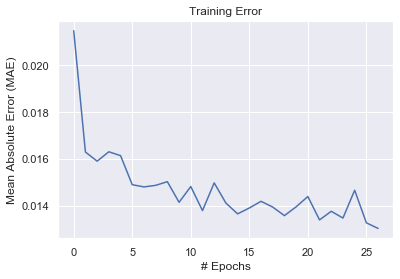

In [22]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(bitcoin_history.epoch, bitcoin_history.history['loss'])
ax1.set_title('Training Error')
ax1.set_xlabel("# Epochs")
ax1.set_ylabel("Mean Absolute Error (MAE)")
plt.show()

In [23]:
# using test_inputs to predict closing price
predicted_closing_price = LSTM_model.predict(LSTM_test_inputs)
# now we inverse_transform the normalised data into real price
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)
# put it into panda frame
df_predicted_closing_price=pd.DataFrame(predicted_closing_price,columns=['Close']) 
# generate predicted date set
predicted_date=[(datetime.datetime.strptime(split_date, '%Y-%m-%d') + 
                 datetime.timedelta(days=window_len+i)).strftime('%Y-%m-%d') for i in range(LSTM_test_outputs.size)]
# add predicted date set into panda frame
df_predicted_closing_price['Date'] = predicted_date
df_predicted_closing_price = df_predicted_closing_price[['Date','Close']]
df_predicted_closing_price = df_predicted_closing_price.assign(Date=pd.to_datetime(df_predicted_closing_price['Date']))
df_predicted_closing_price

,Date,Close
0,2019-01-08,3915.164795
1,2019-01-09,3924.193604
2,2019-01-10,3927.216064
3,2019-01-11,3688.279297
4,2019-01-12,3603.477783
...,...,...
488,2020-05-10,9414.096680
489,2020-05-11,8720.552734
490,2020-05-12,8428.595703
491,2020-05-13,8505.778320


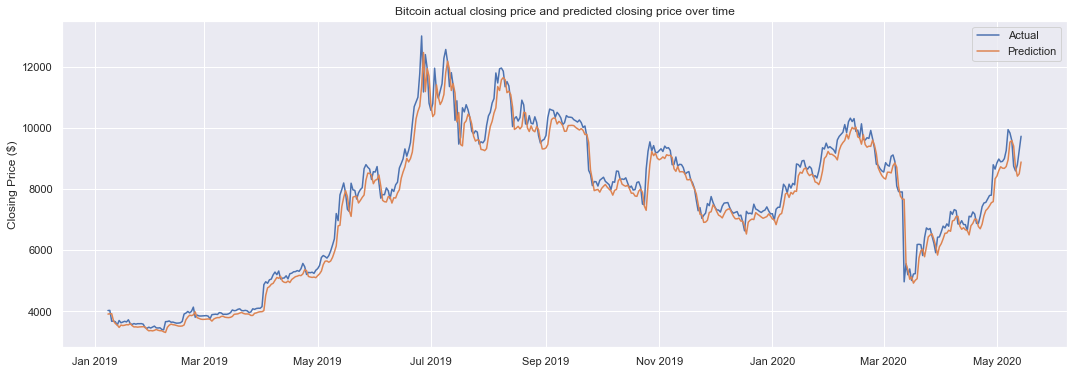

In [24]:
# Create a new figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title('Bitcoin actual closing price and predicted closing price over time')
ax.set_ylabel('Closing Price ($)')
ax.set_xticks([datetime.date(i,j,1) for i in range(2019,2021) for j in [1,3,5,7,9,11]])
ax.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2019,2021) for j in [1,3,5,7,9,11]])
ax.plot(df_bitcoin[df_bitcoin['Date'] >= split_date]['Date'][window_len:],
         df_bitcoin[df_bitcoin['Date'] >= split_date]['Close'][window_len:],label='Actual')
ax.plot(df_predicted_closing_price['Date'],df_predicted_closing_price['Close'],label="Prediction")
ax.legend()
plt.show()

Our LSTM model seems to have performed well on the unseen test set. The most obvious flaw is that it fails to follow the sudden shoot up trend at the end of this period. Furthermore, the model seems to be a little bit overfitting, as even for a very small change in a short term, the model page tracks too similar, for example at the point at Nov,2019.

#### Summary
LSTM is one of the most commonly used neural networks for time series analysis. The ability of LSTM to remember previous information makes it ideal for such tasks. In this project, we saw how we can use LSTM for the Bitcoin closing price prediction. Also the website "coinmarketcap.com" contains the daily price data of most mainstream cryptocurrencies on the market, we can do this prediction on the other  cryptocurrencies such as Ethereum in the future.
From the comparasion between the predicted value and actual value based on the test, we can see neurons and epochs have a great impact on the predicted value.The more neurons and epochs we used, the more precise the predicted value is, and of course the more time we wait. Due to The dropout layer we added, we should not be too worried about overfitting. 
Finally,this project is only used for academic research